In [1]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sn
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### reading and cancatenating csv results

In [3]:
path_ade = '/Users/frank/Documents/maestria/propuesta/experiments/data/predict-ck80-adenoma.csv'
ade_df = pd.read_csv(path_ade, header= None, thousands=',')
ade_df = ade_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
ade_df["GroundTruth"] = 0 
ade_df["Num_video"] = 0
#funcion lambda (para tomar el # del frame): para toda x tal que en la colum Video se parta por '/'
#se toma la última palabra y de esta lo que este por delante (5 cantidad de letras en 'video')
ade_df["Num_video"] = (ade_df.apply(lambda x: int(x.Video.split('/')[-1][5:]), axis=1))
ade_df = ade_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
ade_df['Prob_ser'] = pd.to_numeric(ade_df['Prob_ser'], downcast='float', errors='coerce').fillna(1 - ade_df.Prob_ade - ade_df.Prob_hyp)
ade_df = ade_df.reset_index(drop = True)#para que los indices de las filas esten acorde al nuevo orden
ade_df.head()

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,adenoma_WL/video1,1,0.476314,0.152774,0.370912,0,1
1,adenoma_WL/video1,2,0.129723,0.030330,0.839947,0,1
2,adenoma_WL/video1,3,0.011892,0.059206,0.928902,0,1
3,adenoma_WL/video1,4,0.038663,0.068745,0.892592,0,1
4,adenoma_WL/video1,5,0.567560,0.021606,0.410834,0,1


In [4]:
path_hyp = '/Users/frank/Documents/maestria/propuesta/experiments/data/predict-ck80-hiperplastic.csv'
hyp_df = pd.read_csv(path_hyp, header= None, thousands=',')
hyp_df = hyp_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
hyp_df["GroundTruth"] = 1 
hyp_df["Num_video"] = 0
hyp_df["Num_video"] = (hyp_df.apply(lambda x: int(x.Video.split('/')[-1][5:]), axis=1))
hyp_df = hyp_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
hyp_df = hyp_df.reset_index(drop = True)
#hyp_df.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5])
hyp_df.head()

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,hiperplastic_WL/video41,1,0.010241,0.987595,0.002164,1,41
1,hiperplastic_WL/video41,2,0.002367,0.996345,0.001288,1,41
2,hiperplastic_WL/video41,3,0.028737,0.964201,0.007062,1,41
3,hiperplastic_WL/video41,4,0.029768,0.967768,0.002464,1,41
4,hiperplastic_WL/video41,5,0.056516,0.941292,0.002192,1,41


In [5]:
path_ser = '/Users/frank/Documents/maestria/propuesta/experiments/data/predict-ck80-serrated.csv'
ser_df = pd.read_csv(path_ser, header= None, thousands=',')
ser_df = ser_df.rename(columns={0:"Video", 1:"Frames", 2:"Prob_ade", 3:"Prob_hyp", 4:"Prob_ser"})
ser_df["GroundTruth"] = 2 
ser_df["Num_video"] = 0
ser_df["Num_video"] = (ser_df.apply(lambda x: int(x.Video.split('/')[-1][5:]), axis=1))
ser_df = ser_df.sort_values(by=["Num_video","Frames"], ascending=[True, True])
ser_df = ser_df.reset_index(drop = True)
ser_df.head()

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,serrated_WL/video62,1,0.607379,0.331295,0.061326,2,62
1,serrated_WL/video62,2,0.883557,0.107613,0.008830,2,62
2,serrated_WL/video62,3,0.718731,0.159868,0.121401,2,62
3,serrated_WL/video62,4,0.450333,0.223702,0.325965,2,62
4,serrated_WL/video62,5,0.719998,0.158919,0.121083,2,62


In [6]:
total_df = pd.concat([ade_df, hyp_df, ser_df])
total_df = total_df.reset_index(drop = True)
total_df

,Video,Frames,Prob_ade,Prob_hyp,Prob_ser,GroundTruth,Num_video
0,adenoma_WL/video1,1,4.763145e-01,1.527738e-01,0.370912,0,1
1,adenoma_WL/video1,2,1.297234e-01,3.033010e-02,0.839947,0,1
2,adenoma_WL/video1,3,1.189205e-02,5.920605e-02,0.928902,0,1
3,adenoma_WL/video1,4,3.866266e-02,6.874532e-02,0.892592,0,1
4,adenoma_WL/video1,5,5.675597e-01,2.160592e-02,0.410834,0,1
...,...,...,...,...,...,...,...
36526,serrated_WL/video76,586,4.075854e-04,1.051712e-23,0.999592,2,76
36527,serrated_WL/video76,587,2.619828e-29,0.000000e+00,1.000000,2,76
36528,serrated_WL/video76,588,2.940642e-16,1.956327e-25,1.000000,2,76
36529,serrated_WL/video76,589,1.271120e-08,3.475339e-25,1.000000,2,76


In [7]:
predictions_total_df = pd.DataFrame(columns=["video", 'Num_video',"Prob_ade", 
                                       "Prob_hyp", "Prob_ser","GroundTruth",'Pred','WellPred'])
class_dict = {0:"adenoma_NBI", 1:"hiperplastic_NBI", 2:"serrated_NBI/video15"}
for groundtruth in range(3):
    for num_video in total_df[total_df["GroundTruth"]== groundtruth].Num_video.unique():
        current_df = total_df[(total_df['Num_video']==num_video) & (total_df['GroundTruth']==groundtruth)]
        predictions_total_df.loc[len(predictions_total_df)] = [class_dict[groundtruth]+"video"+str(num_video),
                                                               num_video,
                                                               current_df.Prob_ade.mean(),
                                                               current_df.Prob_hyp.mean(),
                                                               current_df.Prob_ser.mean(),
                                                               groundtruth,
                                                               0,
                                                               0]
predictions_total_df["Pred"] = (predictions_total_df.apply(
    lambda x: int(np.argmax(np.array([x.Prob_ade, x.Prob_hyp, x.Prob_ser]))), axis=1))
predictions_total_df["WellPred"] = (predictions_total_df.apply(
    lambda x: 1 if x.GroundTruth == x.Pred else 0, axis=1))

## Metrics

### basic metrics

In [8]:
y_true = predictions_total_df['GroundTruth'].values
y_true = y_true.tolist()
y_pred = predictions_total_df['Pred'].values
y_pred = y_pred.tolist()
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true')

In [9]:
cm

array([[0.875     , 0.075     , 0.05      ],
       [0.23809524, 0.71428571, 0.04761905],
       [0.26666667, 0.06666667, 0.66666667]])

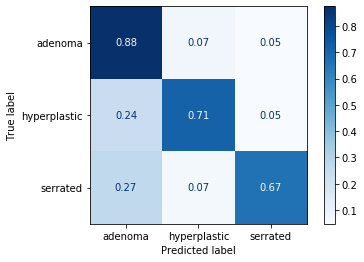

In [11]:
target_names = ['adenoma', 'hyperplastic', 'serrated']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='.2f')
plt.savefig('confusion_matrix_art_Nbi_80.png')

### general report

In [12]:
print(metrics.classification_report(y_true, y_pred, target_names=["adenoma","hiperplastico", "serrated"]))

               precision    recall  f1-score   support

      adenoma       0.80      0.88      0.83        40
hiperplastico       0.79      0.71      0.75        21
     serrated       0.77      0.67      0.71        15

     accuracy                           0.79        76
    macro avg       0.78      0.75      0.77        76
 weighted avg       0.79      0.79      0.79        76



### ROC-AUC curves

In [13]:
def true_labels(class_curves):
    y_true_ade = []
    y_true_hip = []
    y_true_ser = []
    y_true = []

    if(class_curves=="adenoma"):
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(1)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(0)
            
    elif(class_curves=="hiperplastic"):
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(1)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(0)
    else:
        for i in range(len(total_df[total_df["GroundTruth"]==0])):
            y_true_ade.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==1])):
            y_true_hip.append(0)
        for i in range(len(total_df[total_df["GroundTruth"]==2])):
            y_true_ser.append(1)
    y_true.extend(y_true_ade)
    y_true.extend(y_true_hip)
    y_true.extend(y_true_ser)
    return y_true

In [14]:
def roc_auc_values(roc, y_pred, y_true):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred) #,pos_label=2)
    auc = roc_auc_score(y_true, y_pred)
    
    return fpr, tpr, auc

In [13]:
def plot_roc(fpr, tpr, auc):
    
    fig, ax = plt.subplots()
    plt.title(label="ROC polyps types", loc='center')
    ax.plot(fpr[0], tpr[0], label= "adenoma"+", auc="+'%.3f' % auc[0])
    ax.plot(fpr[1], tpr[1], label= "hyperplastic"+", auc="+'%.3f' % auc[1])
    ax.plot(fpr[2], tpr[2], label= "serrated"+", auc="+'%.3f' % auc[2])
    
    axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 2, loc=1 for upper right
    axins.plot(fpr[0], tpr[0], fpr[1], tpr[1], fpr[2], tpr[2])
    axins.set_xlim(0, 0.25) # Limit the region for zoom
    axins.set_ylim(0.5, 0.8)
    
    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)

    mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")

    ax.legend(loc=0)
    plt.savefig('roc-auc-fakeNbiPolyps.png')

In [14]:
fpr, tpr, auc = ([] for _ in range(3))
roc_curves = ["adenoma", "hiperplastic", "serrated"]
for roc in roc_curves:
    if roc=="adenoma":
        y_pred = total_df['Prob_ade'].values        
        y_true = true_labels(roc)
        ade_fpr, ade_tpr, ade_auc = roc_auc_values(roc, y_pred, y_true)
    elif roc=="hiperplastic":
        y_pred = total_df['Prob_hyp'].values
        y_true = true_labels(roc)
        hyp_fpr, hyp_tpr, hyp_auc = roc_auc_values(roc, y_pred, y_true)
    else:
        y_pred = total_df['Prob_ser'].values
        y_true = true_labels(roc)
        ser_fpr, ser_tpr, ser_auc = roc_auc_values(roc, y_pred, y_true)
        
fpr.append(ade_fpr)
fpr.append(hyp_fpr)
fpr.append(ser_fpr)

tpr.append(ade_tpr)
tpr.append(hyp_tpr)
tpr.append(ser_tpr)

auc.append(ade_auc)
auc.append(hyp_auc)
auc.append(ser_auc)

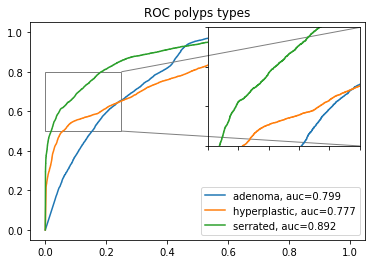

In [15]:
plot_roc(fpr, tpr, auc)